# Creating a Content-based Recommender System


# Libraries for this project



In [30]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import json


## Introduction

Have you ever had a friend ask you to recommend a movie or song based on something they just watched or listened to? It's pretty common, right? You think about what they might like, considering their taste, and suggest something similar. That's basically what a recommender system does, but with a lot more data and a bit more sophistication.

Recommender systems are like your personal assistant, suggesting things you might like based on your preferences and behavior. They're everywhere: Netflix suggests movies, Spotify recommends songs, and Amazon points you to products you might want to buy.

In general, there are three types od recommender systems:
1. **Content-Based**. Imagine you just watched a movie with your favorite genre. A content-based system would suggest other movies with similar genres and plot.
2. **Collaborative Filtering**. Think of Netflix or Spotify, where you get recommendations based on what other users with similar tastes liked.
3. **Hybrid**. Like the name suggests, this recommender system combine both content-based and colaborative filtering to give a more accurate suggestions.


In this project, we're building a content-based recommender system using the TMDB 5000 dataset. We'll create a system that can suggest movies based on their content.


## Dataset

For this project, we're using the TMDB 5000 dataset, which is a collection of movie information gathered from [The Movie Database (TMDB)](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata). This dataset provides a wealth of details about movies, including metadata like titles, genres, plot summaries, cast and crew, release dates, and user ratings.



### Structure of the Dataset
The TMDB 5000 dataset consists of two main files:

1. **movies_metadata.csv**: Contains metadata for each movie, including title, genres, overview, release date, and more.
2. **credits.csv**: Contains information about the cast and crew for each movie.


#### Movies Metadata



In [5]:
movies_metadata_df = pd.read_csv('data/tmdb_5000_movies.csv')
movies_metadata_df.shape

(4803, 20)

In [6]:
movies_metadata_df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


#### Movies Credit

In [7]:
movies_credit_df = pd.read_csv('data/tmdb_5000_credits.csv')
movies_credit_df.shape

(4803, 4)

In [8]:
movies_credit_df.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


## Data Preprocessing

In [9]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [10]:
movies_credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


#### Combining both tables

In [17]:
movies_df = movies_metadata_df.merge(movies_credit_df.drop('title',axis=1),left_on='id',right_on='movie_id', how='left').drop('movie_id', axis=1)

### Handling missing value

As can be seen in the previous chunk of code, there are some columns with missing values. Generally, we need to handle these missing values. In this case, we are lucky because most of the missing values are not directly related to the content of the movie. For example, the homepage is unlikely to be a significant factor when recommending a movie.

On the other hand, the overview column contains a summary of the movie's plot, which is crucial for our recommendation system. Therefore, we need to handle missing values in this column carefully.

For now, we will ignore missing values in columns that do not directly impact the movie content and drop rows with missing values in crucial columns like overview.

Although tagline can contains information crucial for the content, we choose not to drop rows with missing values in the tagline column. The tagline is a more condensed version of the information in the overview, meaning its information is already covered by the overview. Therefore, the absence of a tagline does not significantly impact our ability to recommend movies based on their content. Additionally not all movie have a tagline.

In [27]:
movies_df = movies_df[~movies_df['overview'].isna()].reset_index(drop=True)

In [28]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4800 non-null   int64  
 1   genres                4800 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4800 non-null   int64  
 4   keywords              4800 non-null   object 
 5   original_language     4800 non-null   object 
 6   original_title        4800 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4800 non-null   float64
 9   production_companies  4800 non-null   object 
 10  production_countries  4800 non-null   object 
 11  release_date          4799 non-null   object 
 12  revenue               4800 non-null   int64  
 13  runtime               4800 non-null   float64
 14  spoken_languages      4800 non-null   object 
 15  status               

## Exploratory Data Analysis

Since we have a content-based recommender system in mind, we will explore the data that contains information about the content of the movie. Imagine that your friend comes to you and says, "I've just watched The Dark Knight and I love it. Do you know any other movies like that?" There are several factors you can consider to give your friend recommendations:

1. **The Genre**. Maybe your friend likes action-packed movies or superhero movies. Considering this, you can recommend other action or superhero movies.
2. **Keywords of the Movie**. This movie might have some keywords attached to it, like DC Comics, superhero, Batman. Considering this, you can recommend not only random superhero movies but something like Superman or Wonder Woman that share the same keywords.
3. **The Plot**. Maybe your friend is interested in movies with similar plots. A movie where the hero has to save a city from a terrorist attack, for example.
4. **The Director**. Each movie director has their own style. Maybe your friend is more interested in the style of Christopher Nolan.


Considering all these factors and many others is the key to making a reliable recommender system.




### Exploring Genre

#### How many Genre a movie have?

In [31]:
movies_df['genres'].apply(lambda x: len(json.loads(x))).describe()

count    4800.000000
mean        2.532708
std         1.120651
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: genres, dtype: float64

<Axes: xlabel='genres'>

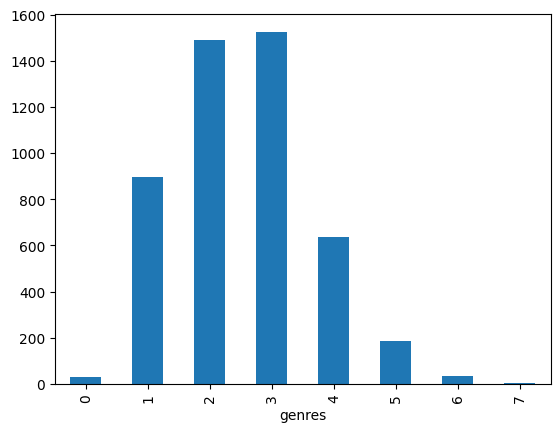

In [33]:
movies_df['genres'].apply(lambda x: len(json.loads(x))).value_counts().sort_index().plot.bar()

As can be seen in the description and the plot, a movie can have a range of 0-7 genres. A movie with 0 genres can be considered as a movie for which we don't know the genre. From the visualization, we can see that most movies have 2 to 3 genres associated with them.


#### Genre Distribution

In [40]:
def create_genre_list(x):
    genre_movie = []
    jdata = json.loads(x)
    for d in jdata:
        genre_movie.append(d['name'])
    return genre_movie


genre_series = []

for i, r in movies_df.iterrows():
    genre_series += create_genre_list(r['genres'])

genre_series = pd.Series(genre_series)


<Axes: >

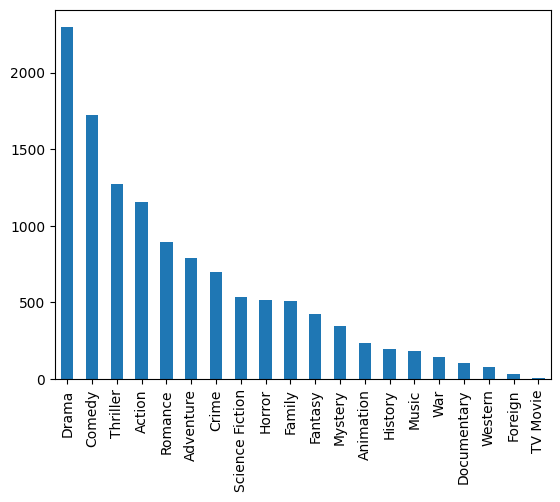

In [44]:
genre_series.value_counts().plot.bar()

In [47]:
len(genre_series.value_counts())

20

We can see there are 20 genres recorded in total. From these 20 genres, the most common one is drama. However, keep in mind that what makes a movie unique is not just a single genre but combinations of genres. For example, an Action-Comedy movie will have a very different tone from an Action-Mystery movie. Therefore, it is important to maintain this connection later when we create our recommender system.

### Exploring Keywords

#### Numbers of Keywords in a movie

In [48]:
movies_df['keywords'].apply(lambda x: len(json.loads(x))).describe()

count    4800.000000
mean        7.538750
std         6.280662
min         0.000000
25%         3.000000
50%         6.000000
75%        11.000000
max        97.000000
Name: keywords, dtype: float64

<Axes: xlabel='keywords'>

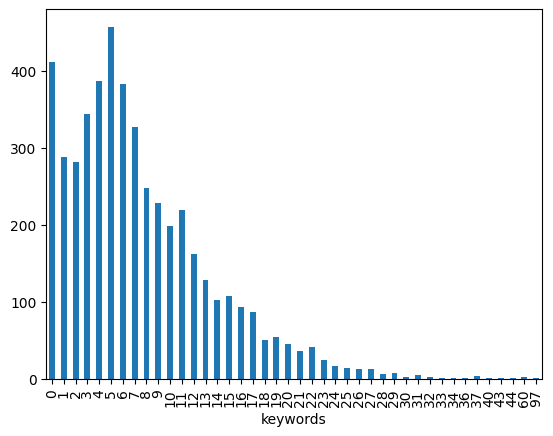

In [49]:
movies_df['keywords'].apply(lambda x: len(json.loads(x))).value_counts().sort_index().plot.bar()


Unlike genres, a movie can have a lot more keywords associated with it. In our database, it can range up to 97 keywords, with a median of 6. This means half of the movies have at least 6 keywords attached to them. 

### How many keywords there are

In [53]:
keywords = []
for i,r in movies_df.iterrows():
    jdata = json.loads(r['keywords'])
    for d in jdata:
        keywords.append(d['name'])

keywords = pd.Series(keywords)

In [61]:
len(keywords.unique())

9808

In [71]:
keywords.value_counts().describe()

count    9808.000000
mean        3.689437
std         9.669485
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       324.000000
Name: count, dtype: float64

The total number of keywords available is 9808, however, only a quarter of them appear in at least three different movies. We can keep this in mind, since a keyword that appears only in one or two movies will not provide much information for the recommender system.

### Exploring Overview/The plot description

#### How many words contained in an overview?

In [76]:
movies_df['overview'].apply(lambda x: len(x.split())).describe()

count    4800.000000
mean       52.157292
std        27.867016
min         0.000000
25%        30.000000
50%        48.000000
75%        67.000000
max       175.000000
Name: overview, dtype: float64

<Axes: >

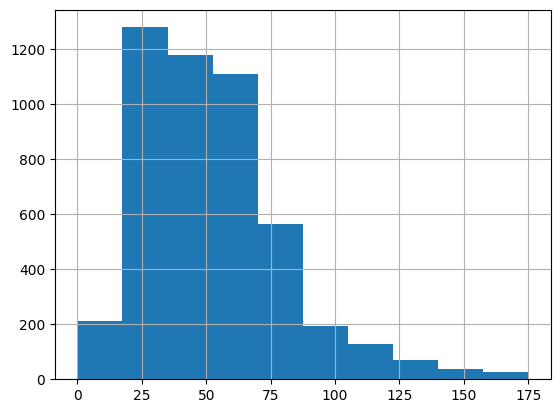

In [77]:
movies_df['overview'].apply(lambda x: len(x.split())).hist()

In [81]:
movies_df[movies_df['overview'].apply(lambda x: len(x.split())) == 0]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
4399,0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 35, ""nam...",NaN,43630,[],en,The Helix... Loaded,,0.0206,[],...,0,97.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Rumored,NaN,The Helix... Loaded,4.8,2,[],[]


As can be seen that the range of overview length is between 0 to 175. Remember that we've drop a movie with no overview. It seems like there are still a movie that don't have an overview. Since it's only one movie i think it is fair to also drop this movie

In [89]:
movies_df = movies_df[movies_df['overview'].apply(lambda x: len(x.split())) > 0].reset_index(drop=True)

### Exploring Director

#### Extracting Director from the Crew

In [176]:
def return_director(x):

    jdata = json.loads(x)
    for d in jdata:
        if d['job'] == 'Director':
            return d['name']
    
    return ''

In [177]:
movies_df['crew'].apply(return_director).value_counts().describe()

count    2347.000000
mean        2.044738
std         2.173457
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        29.000000
Name: count, dtype: float64

<Axes: xlabel='crew'>

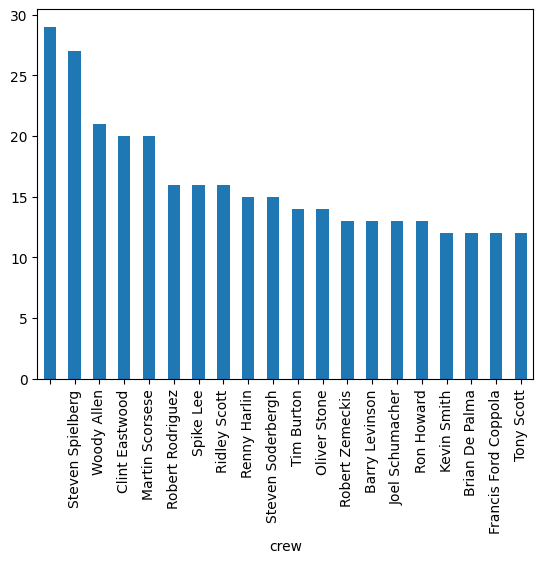

In [178]:
movies_df['crew'].apply(return_director).value_counts()[:20].plot.bar()

In [179]:
movies_df['director'] = movies_df['crew'].apply(return_director)

There are 2346 director recorded in the data, however the majority of them only have one movie directed by them. With the same logic as keywords, we need to keep in mind that the director with only few movies will not enrich our recommender system

## Feature Engineering

### Considering Ranking and Scoring

When you recommend something to someone, you usually rank options based on how well they match what the person likes. In recommender systems, we do the same by calculating a score for each item. This score tells us how relevant each item is to the user's interests, and we use these scores to rank the items.

In a recommender system, feature engineering is all about transforming raw data into something meaningful that can be used to make recommendations. Considering scoring in recommender systems, we need to transform all the content we have into something that can be quantified. In other words, we have to extract the features into vectors that we can calculate the similarities.

### Genres

For our genres, we want to make a vector representation that considers that a movie can have more than one genre. Since there are only 20 genres available, it is reasonable for us to use a binary vector.

For example, if there are three genres only: Action, Drama, and Comedy:
* A movie with Action-Drama genres will be represented with 1 1 0.
* A movie with Drama-Comedy genres will be represented with 0 1 1.

In [132]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def extract_genre(X):
    genre_matrix = []
    for d in X:
        row_genres = []
        jdata = json.loads(d)
        for j in jdata:
            row_genres.append(j['name'])
        genre_matrix.append(row_genres)

    return genre_matrix

genre_extractor = FunctionTransformer(extract_genre)

In [122]:
genre_vectorizer = CountVectorizer(analyzer= lambda x: x, binary=True)

genre_matrix = genre_vectorizer.fit_transform(genre_extractor.fit_transform(movies_df['genres'])).toarray()

In [127]:
genre_matrix

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Keywords

We're using TF-IDF (Term Frequency-Inverse Document Frequency) to convert keywords into vectors. TF-IDF helps capture the importance of each keyword by balancing how often a keyword appears in a movie against how common it is across all movies. This way, unique keywords for specific movies get more weight, while common ones get less.

Since we know that most keywords appear only once or twice, we won't need to map those keywords to the vector. This can reduce our dimensionality significantly without losing much information. For now, we will map only keywords that appear at least 5 times.





In [128]:
def extract_keywords(X):
    keywords_matrix = []
    for d in X:
        row_keywords = []
        jdata = json.loads(d)
        for j in jdata:
            row_keywords.append(j['name'])
        keywords_matrix.append(row_keywords)

    return keywords_matrix

keywords_extractor = FunctionTransformer(extract_keywords)

In [137]:
keywords_vectorizer = TfidfVectorizer(analyzer= lambda x: x, min_df=5, binary=True)
keywords_matrix = keywords_vectorizer.fit_transform(keywords_extractor.fit_transform(movies_df['keywords'])).toarray()

In [146]:
keywords_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Overview

For plot overviews, we will use Sentence-BERT (SBERT) to create embeddings. Sentence Transformers, based on the SBERT architecture, allow us to convert text into high-dimensional vectors that capture the semantic meaning of the text.

Unlike simple TF-IDF, SBERT captures the deeper semantic meaning of the text, understanding the context and relationships between words. SBERT is particularly effective for longer texts like plot overviews, providing a more nuanced representation than TF-IDF.
Using SBERT embeddings for plot overviews helps us create rich, meaningful representations of the movie plots, enhancing the quality of our recommendations.




In [157]:
from sklearn.base import BaseEstimator, TransformerMixin
from sentence_transformers import SentenceTransformer


class SbertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="all-MiniLM-L6-v2") -> None:
        self.model_name =model_name
        self.model = SentenceTransformer(model_name)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.model.encode(X.str.lower())

In [159]:
overview_embedder = SbertTransformer() # Using small model
overview_embeddings = overview_embedder.fit_transform(movies_df['overview'])

In [161]:
overview_embeddings.shape

(4799, 384)

### Director

We can use similar logic as keywords and genres to vectorize director information. Since director with a few movie wont help us much in term of recommendation, we will use only director with more than 4 movie to vectorize. Due to the fact a movie can only have one director we will be usinng binary representation instead of tfidf

In [180]:
movies_df['director']

0           James Cameron
1          Gore Verbinski
2              Sam Mendes
3       Christopher Nolan
4          Andrew Stanton
              ...        
4794     Robert Rodriguez
4795         Edward Burns
4796          Scott Smith
4797          Daniel Hsia
4798     Brian Herzlinger
Name: director, Length: 4799, dtype: object

In [193]:
director_vectorizer = CountVectorizer(analyzer= lambda x: [x] if x != '' else [], binary=True, min_df=5)


director_matrix = director_vectorizer.fit_transform(movies_df['director']).toarray()

In [195]:
director_matrix.shape

(4799, 211)

### Putting it Together

In [197]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


#### Creating Pipeline for Feature Extraction

In [202]:
# Pipeline for Genre Feature Extraction

genre_pipeline = Pipeline([
    ('genre_extractor', FunctionTransformer(extract_genre)),
    ('genre_vectorizer', CountVectorizer(analyzer= lambda x: x, binary=True))
])


# Pipeline for Keywords Feature Extraction

keywords_pipeline = Pipeline([
    ('keywords_extractor', FunctionTransformer(extract_keywords)),
    ('keywords_vectorizer', TfidfVectorizer(analyzer= lambda x: x, min_df=5, binary=True))
])



#### Joining all feature

In [203]:
feature_extractor = ColumnTransformer([
    ('genres_pipeline', genre_pipeline, "genres"),
    ('keywords_pipeline', keywords_pipeline, "keywords"),
    ('overview_pipeline', SbertTransformer(), "overview"),
    ('director_pipeline', CountVectorizer(analyzer= lambda x: [x] if x != '' else [], binary=True, min_df=5), "director")
])

In [206]:
feature_matrix = feature_extractor.fit_transform(movies_df).toarray()

In [212]:
feature_matrix

(4799, 2322)

## Build a Recommender System

Remember that I mentioned about scoring and ranking. Now in order to actually recommend a movie, we need to score their similirarity to each other. There are several ways to do this, but the most common one for data involving text is **Cosine Similarity**.

Cosine similarity measures how similar two items are by looking at the angle between their vectors. Think of it as comparing the direction of two arrows, regardless of their length. If the arrows point in the same direction, they're similar. In addition to that, It's quick and can handle lots of data without much fuss.

In [257]:
movies_list = movies_df[['id','original_title']].copy()

In [258]:
similarity_matrix = cosine_similarity(feature_matrix, feature_matrix)

In [270]:
def find_similar_movie_using_similarity(movie_id: int):
    indx = movies_list[movies_list['id'] == movie_id].index.tolist()[0]
    top_similar = sorted(list(enumerate(similarity_matrix[indx])), key=lambda x: x[1], reverse=True)[1:11]
    recommended_movies = movies_list.iloc[[t[0] for t in top_similar]].copy()
    recommended_movies['similarity_score'] = [t[1] for t in top_similar]
    return recommended_movies

### Running the Recommender Function

Now let's use this recommender system to recommend movies to our friend who just watched Batman Begins.

In [274]:
movies_list[movies_list['original_title'].str.contains('Batman')]

,id,original_title
9,209112,Batman v Superman: Dawn of Justice
119,272,Batman Begins
210,415,Batman & Robin
299,414,Batman Forever
428,364,Batman Returns
1359,268,Batman
3853,142061,"Batman: The Dark Knight Returns, Part 2"
4265,2661,Batman


In [275]:
batman_begins_id = 272

In [276]:
find_similar_movie_using_similarity(batman_begins_id)

,id,original_title,similarity_score
65,155,The Dark Knight,0.792444
3,49026,The Dark Knight Rises,0.770914
3325,312113,Black November,0.663642
1742,254473,Brick Mansions,0.659899
4634,378237,Amidst the Devil's Wings,0.630629
3358,22314,In Too Deep,0.625375
1486,7220,The Punisher,0.624695
3818,34769,Defendor,0.622456
3827,9516,Menace II Society,0.612793
1661,9989,Antitrust,0.607391


As can be seen from our algorithm, when asked to recommend movies like "Batman Begins," it recommends "The Dark Knight" and "The Dark Knight Rises," which are sequels to the movie. On top of that, we also see movies with some detective and superhero vibes. This indicates that our content-based recommender system is effectively identifying and recommending movies that share significant characteristics with the user's input, thus providing relevant and meaningful suggestions.

## Improving Recomender System

Can we improve this model? Yes. In order to improve a model, we need a strategy to quantify the performance of the model itself. In terms of recommender systems, one common evaluation metric is Precision at K (P@K). Precision at K measures the relevance of the top K recommendations made by the system. It is defined as the proportion of recommended items in the top K set that are relevant.

Unfortunately, our dataset is not ideal for evaluating the recommender system since we don't have the actual user consumption data. Without knowing what movies users have actually watched and liked, we can't accurately measure how well our recommendations match user preferences.

That being said, there are several strategies to improve the model:
1. **Give Different Weight to Each Feature:** Currently, we are treating every feature as equally important. Depending on the case, this might not be the most optimal. By adjusting the weights of different features (e.g., giving more importance to plot similarity over genre similarity), we can potentially improve the relevance of our recommendations.
    
2. **Add More Relevant Features:** We can incorporate additional features that are relevant to the content of the movie, such as the cast, the director, or even more granular details like the sound engineer. These additional features can provide a richer context for making recommendations.

3. **Combine Content-Based Approach with Collaborative Filtering:** Creating a hybrid recommender system by combining content-based filtering with collaborative filtering can leverage the strengths of both approaches. While content-based filtering focuses on item attributes, collaborative filtering leverages user behavior and preferences. This combination can result in more accurate and personalized recommendations.


## Conclusion


Building a content-based recommender system using the TMDB 5000 dataset has allowed us to explore various aspects of feature engineering and similarity scoring. By converting genres into binary vectors, using TF-IDF for keywords, and employing SBERT for plot overviews, we created a comprehensive model capable of providing relevant movie recommendations.

Our model, when asked to recommend movies like "Batman Begins," successfully suggested sequels like "The Dark Knight" and "The Dark Knight Rises," as well as other movies with similar detective and superhero vibes. This demonstrates the effectiveness of our content-based approach in capturing the nuances of movie content.

However, there is always room for improvement. Precision at K (P@K) is a common metric for evaluating recommender systems, but our dataset lacks actual user consumption data, which limits our ability to accurately measure performance.